<a href="https://colab.research.google.com/github/kurshid1991/Breastcancer_ML-modelling/blob/main/CNN_breakHisv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [14]:
pwd

'/content/drive/MyDrive/images'

In [15]:
import os
import pandas as pd

# Base directory for your images on Google Drive
base_dir = '/content/drive/MyDrive/images'

# List to hold the data
data = []

# Recursively walk through all folders
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            full_path = os.path.join(root, file).replace('\\', '/')
            parts = full_path.replace(base_dir, '').strip('/').split('/')

            # Extract label and subtype from the folder hierarchy
            label = parts[1] if len(parts) > 1 else 'unknown'  # Magnification (e.g., 100X)
            subtype = parts[2] if len(parts) > 2 else 'unknown'  # Tumor subtype

            # Ensure subtype is one of the valid 8 subtypes
            valid_subtypes = ['DC', 'F', 'MC', 'LC', 'TA', 'PC', 'PT', 'A']
            if subtype not in valid_subtypes:
                continue  # Skip if the subtype is invalid

            # Append data
            data.append({
                'filepath': full_path,
                'label': label,
                'subtype': subtype
            })

# Convert the data to a DataFrame
df_summary = pd.DataFrame(data)

# Save the summary CSV file
summary_csv_path = '/content/drive/MyDrive/summary_clean.csv'
df_summary.to_csv(summary_csv_path, index=False)

print(f"✅ CSV created with {len(df_summary)} image entries: {summary_csv_path}")
print(df_summary.head())


✅ CSV created with 7914 image entries: /content/drive/MyDrive/summary_clean.csv
                                            filepath      label subtype
0  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
1  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
2  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
3  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
4  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC


In [20]:
import pandas as pd

# Load the CSV
df = pd.read_csv('/content/drive/MyDrive/summary_clean.csv')

# Basic info
print("🔍 Basic Info:")
print(df.info())

# Preview the data
print("\n📋 Head of Data:")
print(df.head())

# Check for missing values
print("\n❗ Missing Values:")
print(df.isnull().sum())


🔍 Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7914 entries, 0 to 7913
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filepath  7914 non-null   object
 1   label     7914 non-null   object
 2   subtype   7914 non-null   object
dtypes: object(3)
memory usage: 185.6+ KB
None

📋 Head of Data:
                                            filepath      label subtype
0  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
1  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
2  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
3  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC
4  /content/drive/MyDrive/images/100X/malignant/M...  malignant      MC

❗ Missing Values:
filepath    0
label       0
subtype     0
dtype: int64


In [21]:
# Count of images by label (e.g., 100X, 200X, 400X)
print("\n🔢 Images by Magnification (label):")
print(df['label'].value_counts())

# Count of images by subtype
print("\n🔢 Images by Subtype:")
print(df['subtype'].value_counts())



🔢 Images by Magnification (label):
label
malignant    5434
benign       2480
Name: count, dtype: int64

🔢 Images by Subtype:
subtype
DC    3451
F     1014
MC     792
LC     626
TA     569
PC     565
PT     453
A      444
Name: count, dtype: int64


In [22]:
# Grouped count
grouped = df.groupby(['label', 'subtype']).size().reset_index(name='count')
print("\n📊 Count by Magnification and Subtype:")
print(grouped)



📊 Count by Magnification and Subtype:
       label subtype  count
0     benign       A    444
1     benign       F   1014
2     benign      PT    453
3     benign      TA    569
4  malignant      DC   3451
5  malignant      LC    626
6  malignant      MC    792
7  malignant      PC    565


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


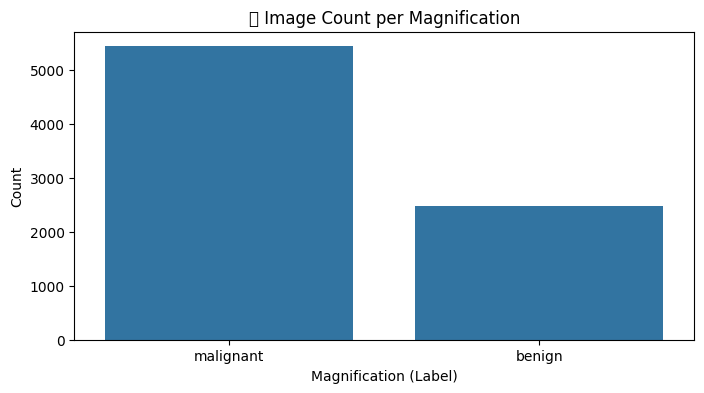

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


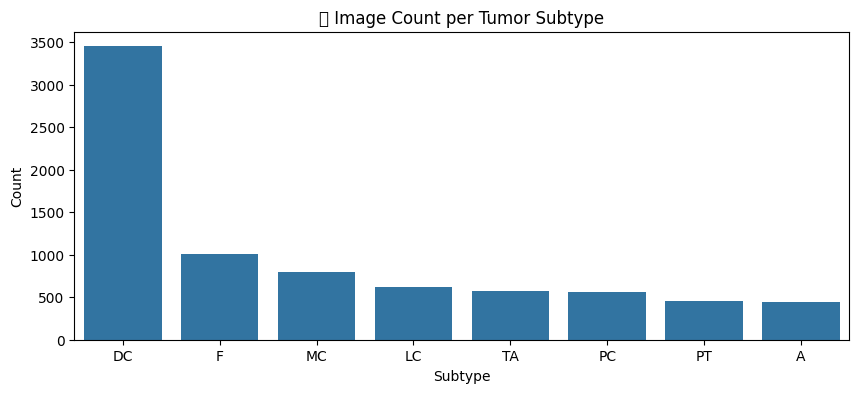

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Barplot: Images per magnification (label)
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('🧪 Image Count per Magnification')
plt.xlabel('Magnification (Label)')
plt.ylabel('Count')
plt.show()

# Barplot: Images per subtype
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='subtype', order=df['subtype'].value_counts().index)
plt.title('🧬 Image Count per Tumor Subtype')
plt.xlabel('Subtype')
plt.ylabel('Count')
plt.show()



In [25]:
# Check for duplicates in file paths
duplicate_paths = df.duplicated(subset=['filepath']).sum()
print(f"🔁 Duplicate file paths: {duplicate_paths}")


🔁 Duplicate file paths: 0


In [26]:
import os
import numpy as np
from PIL import Image
from collections import defaultdict
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

# Parameters
base_dir = '/content/drive/MyDrive/images'  # <-- Change if needed
image_size = (224, 224)
max_images_per_subtype = 444
valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')

# Valid subtypes
valid_subtypes = ['DC', 'F', 'MC', 'LC', 'TA', 'PC', 'PT', 'A']

# Store collected data
X = []
y = []

# Track how many images collected per subtype
subtype_counter = defaultdict(int)

# Traverse and collect images
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(valid_extensions):
            filepath = os.path.join(root, file)

            # Extract subtype from folder name
            parts = filepath.replace(base_dir, '').strip('/').split('/')
            subtype = parts[-2] if len(parts) >= 2 else None  # Assumes subtype is second last folder

            if subtype in valid_subtypes and subtype_counter[subtype] < max_images_per_subtype:
                try:
                    img = Image.open(filepath).convert('RGB')
                    img = img.resize(image_size)
                    img_array = np.array(img)

                    X.append(img_array)
                    y.append(subtype)
                    subtype_counter[subtype] += 1
                except Exception as e:
                    print(f"❌ Failed to process {filepath}: {e}")

# Convert to NumPy arrays
X = np.array(X)
print(f"✅ Loaded {X.shape[0]} images of shape {X.shape[1:]}")

# One-hot encode labels
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)

print(f"✅ One-hot encoded labels: {y_encoded.shape}")
print(f"Classes: {lb.classes_}")


✅ Loaded 3552 images of shape (224, 224, 3)
✅ One-hot encoded labels: (3552, 8)
Classes: ['A' 'DC' 'F' 'LC' 'MC' 'PC' 'PT' 'TA']


In [27]:
X

array([[[[180, 157, 178],
         [177, 147, 176],
         [163, 133, 164],
         ...,
         [184, 159, 169],
         [175, 153, 162],
         [184, 171, 179]],

        [[183, 154, 176],
         [191, 159, 189],
         [179, 147, 182],
         ...,
         [203, 183, 191],
         [195, 178, 184],
         [181, 174, 178]],

        [[189, 159, 180],
         [206, 170, 201],
         [201, 164, 201],
         ...,
         [202, 190, 195],
         [203, 192, 195],
         [191, 186, 189]],

        ...,

        [[210, 221, 207],
         [213, 222, 211],
         [213, 221, 214],
         ...,
         [190, 165, 179],
         [206, 178, 196],
         [192, 167, 189]],

        [[211, 222, 209],
         [213, 222, 211],
         [213, 222, 213],
         ...,
         [189, 164, 178],
         [206, 178, 195],
         [198, 174, 195]],

        [[210, 220, 207],
         [212, 222, 209],
         [212, 222, 211],
         ...,
         [191, 166, 181],
        

In [32]:
# Normalize pixel values to [0, 1]
X = X.astype('float32') / 255.0

print(f"✅ X normalized. Min: {X.min()}, Max: {X.max()}")


✅ X normalized. Min: 0.0, Max: 1.0


In [33]:
X

array([[[[0.7058824 , 0.6156863 , 0.69803923],
         [0.69411767, 0.5764706 , 0.6901961 ],
         [0.6392157 , 0.52156866, 0.6431373 ],
         ...,
         [0.72156864, 0.62352943, 0.6627451 ],
         [0.6862745 , 0.6       , 0.63529414],
         [0.72156864, 0.67058825, 0.7019608 ]],

        [[0.7176471 , 0.6039216 , 0.6901961 ],
         [0.7490196 , 0.62352943, 0.7411765 ],
         [0.7019608 , 0.5764706 , 0.7137255 ],
         ...,
         [0.79607844, 0.7176471 , 0.7490196 ],
         [0.7647059 , 0.69803923, 0.72156864],
         [0.70980394, 0.68235296, 0.69803923]],

        [[0.7411765 , 0.62352943, 0.7058824 ],
         [0.80784315, 0.6666667 , 0.7882353 ],
         [0.7882353 , 0.6431373 , 0.7882353 ],
         ...,
         [0.7921569 , 0.74509805, 0.7647059 ],
         [0.79607844, 0.7529412 , 0.7647059 ],
         [0.7490196 , 0.7294118 , 0.7411765 ]],

        ...,

        [[0.8235294 , 0.8666667 , 0.8117647 ],
         [0.8352941 , 0.87058824, 0.827451  ]

In [34]:
from sklearn.preprocessing import LabelBinarizer

# One-hot encode subtype labels
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)

print(f"✅ y one-hot encoded. Shape: {y_encoded.shape}")
print(f"Classes: {lb.classes_}")
from sklearn.preprocessing import LabelBinarizer

# One-hot encode subtype labels
lb = LabelBinarizer()
y_encoded = lb.fit_transform(y)

print(f"✅ y one-hot encoded. Shape: {y_encoded.shape}")
print(f"Classes: {lb.classes_}")


✅ y one-hot encoded. Shape: (3552, 8)
Classes: ['A' 'DC' 'F' 'LC' 'MC' 'PC' 'PT' 'TA']
✅ y one-hot encoded. Shape: (3552, 8)
Classes: ['A' 'DC' 'F' 'LC' 'MC' 'PC' 'PT' 'TA']


In [35]:
y

['MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',
 'MC',